In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
import mlflow
#import torch
#from torchvision import models

In [2]:

# Load the model from an .h5 file
model = load_model('resnet50_v3_callbacks.h5')

In [11]:
# Load the model from Mlflow

mlflow.set_tracking_uri('https://champi.heuzef.com') 
# heuzef_efficientnetb1_010_artifacts
# Load the model from the specific experiment and run
model_uri = 'mlflow-artifacts:/103379370584144202/93ce2df782da48108f127f3e6c4adb8b/artifacts/heuzef_efficientnetb1_010_artifacts'  # artifact location
model = mlflow.keras.load_model(model_uri)
#local_model_path = 'heuzef_efficientnetb1_010_local.h5'
#model.save(local_model_path)

In [6]:
#model.summary()

In [7]:
def gradcam_with_display(model, img_path, pred_index=None, alpha=0.4):
    '''
    Function to visualize Grad-CAM heatmaps and display them over the original image.

    Parameters:
    - model: The trained Keras model.
    - img_path: Path to the original image for display.
    - pred_index: Index of the predicted class (optional). If None, the top predicted class is used.
    - alpha: Transparency for heatmap overlay (default is 0.4).
    
    Returns:
    - heatmap: The computed heatmap.
    '''
    
    # Automatically get the last convolutional layer
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if 'conv' in layer.name or 'conv' in layer.__class__.__name__.lower():
            last_conv_layer_name = layer.name
            break
    
    if last_conv_layer_name is None:
        raise ValueError("No convolutional layer found in the model.")

    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # Use ResNet preprocessing

    # Create a Grad-CAM model
    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients of the top predicted class for the output feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Pool the gradients over all the axes leaving only the last one
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weigh the feature map with the pooled gradients
    conv_outputs = conv_outputs[0].numpy()

    # Multiply each channel by the corresponding gradient
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # Compute the heatmap by averaging over all channels
    heatmap = np.mean(conv_outputs, axis=-1)

    # ReLU to keep only positive activations and normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to the original image size
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.clip(heatmap, 0, 255)
    heatmap = Image.fromarray(heatmap).resize((img.size[0], img.size[1]), Image.BILINEAR)
    heatmap = np.array(heatmap)

    # Create a heatmap using Matplotlib
    heatmap = plt.get_cmap('jet')(heatmap / 255.0)[:, :, :3]  # Convert to RGB format
    heatmap = (heatmap * 255).astype(np.uint8)

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap * alpha + np.array(img)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    # Display the result using Matplotlib
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

    return heatmap

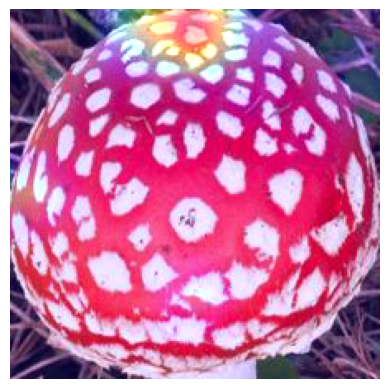

In [12]:
img_path = 'C:/Users/vsavelev/GITHUB/DS_projet/LAYER2/MO/validation/373/145025.jpg'
heatmap = gradcam_with_display(model, img_path, pred_index=None, alpha=0.4)
